In [1]:
import numpy as np
import pyaccel as pa
from apsuite.commisslib.emit_exchange import EmittanceExchangeSimul
from apsuite.orbcorr import OrbitCorr
from auxiliar_scripts.aux_functions import extract_quad_ramp, emittances_from_beam_size, \
    extraction_analysis, gauss, plot_ext_time_scan
import pymodels as pm
import matplotlib.pyplot as plt
import matplotlib as mpl
from mathphys.functions import save_pickle, load_pickle
# plt.style.use(['science', 'notebook'])

# Comparing the effect of radiation on different S

In [3]:
simul2 = EmittanceExchangeSimul(s=5, c=0.02, radiation=False, quad='QD')

In [4]:
simul2.env_emit_exchange(indices=[0])

---------------------Tracking particles----------------------
Initial delta = -0.110 
 N = 108
 C=2.000[%], S=5.000
step 0	

step 100	Done!


In [3]:
simul2._calc_delta()

-0.10995406877858649

In [24]:
dk = simul2._calc_dk(-0.110)

In [19]:
idx = simul2.quad_idxs
k_default = simul2.model[idx[0]].K

In [25]:
pa.lattice.set_attribute(simul2.model, 'K', idx, k_default+dk)

In [26]:
eqparams = pa.optics.EqParamsFromBeamEnvelope(simul2.model)

In [5]:
eqparams.tune1, eqparams.tune2

NameError: name 'eqparams' is not defined

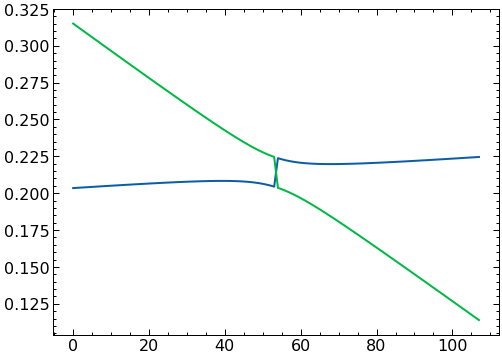

In [6]:
plt.plot(simul2.tunes[0])
plt.plot(simul2.tunes[1])

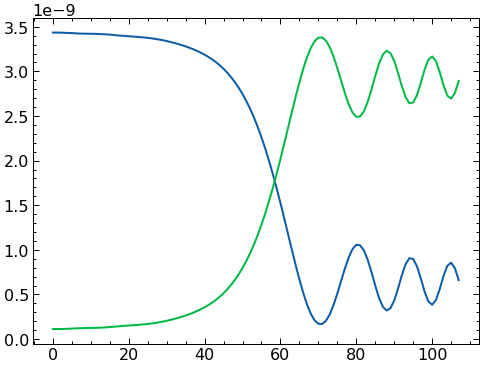

In [7]:
plt.plot(simul2.emittances[0])
plt.plot(simul2.emittances[1])

# Emittance exchange in the TS screens

## Some initial testes

Getting emittances through the process of emittance exchange

In [8]:
c = 0.0061
s = 2
# error_angle = 4e-3  # [rad]
sim = EmittanceExchangeSimul(init_delta = -0.0726, c=c, radiation=True, s=s)
# Adding dipole rotation erros>
# pa.lattice.set_error_rotation_roll(sim.model, dips_id[0], error_angle)

NameError: name 'dips_id' is not defined

In [7]:
eqparams = pa.optics.EqParamsFromBeamEnvelope(sim.model)
eqparams.emit1, eqparams.emit2

(3.4509798380132736e-09, 1.1889652228530886e-11)

In [128]:
septf_idx = pa.lattice.find_indices(sim.model, 'fam_name','EjeSeptF')

In [91]:
sim.env_emit_exchange(indices=septf_idx[0])

---------------------Tracking particles----------------------
Initial delta = -0.073 
 N = 1956
 C=0.610[%], S=2.000
step 0	

step 100	step 200	step 300	step 400	step 500	

step 600	step 700	step 800	step 900	step 1000	

step 1100	step 1200	step 1300	step 1400	step 1500	

step 1600	step 1700	step 1800	step 1900	Done!


In [92]:
save_pickle(sim, f'data/sim_object_s={s}_c={c}_dip_rot_errors_{error_angle}')

In [125]:
# sim = load_pickle(f'data/sim_object_s={s}_c={c}_dip_rot_errors_{error_angle}')
sim = load_pickle(f'data/sim_object_s={s}_c={c}')

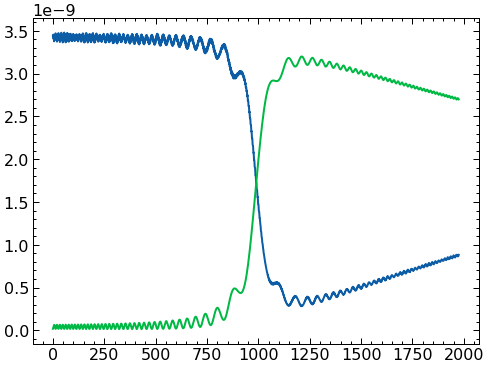

In [126]:
plt.plot(sim._emittances[0])
plt.plot(sim._emittances[1])
plt.show()

## Teorical beam sizes by using optical functions

In [80]:
ts, default_twi0 = pm.ts.create_accelerator()
screens_indices = pa.lattice.find_indices(ts, 'fam_name', 'Scrn')
labels =  ("TS-01:DI-Scrn",
            "TS-02:DI-Scrn",
            "TS-03:DI-Scrn",
            "TS-04:DI-Scrn-1",
            "TS-04:DI-Scrn-2",
            "TS-04:DI-Scrn-3")

In [96]:
bo = sim.model[:]

# Finding the initial condition for the TS Line
septf_idx = pa.lattice.find_indices(sim.model, 'fam_name','EjeSeptF')
bo_twiss, _ = pa.optics.calc_twiss(bo)
bo_twiss = bo_twiss[septf_idx[0]+1]

In [101]:
print(bo_twiss)

spos          : +4.746e+02
rx, ry        : -5.758e-05, +5.163e-07
px, py        : -1.723e-05, -1.454e-07
de, dl        : -9.209e-05, -8.274e-02
mux, muy      : +1.158e+02, +4.378e+01
betax, betay  : +7.914e+00, +1.237e+01
alphax, alphay: -2.419e+00, +2.038e+00
etax, etapx   : +2.130e-01, +7.029e-02
etay, etapy   : -3.508e-03, +9.878e-04


In [83]:
ejeidx = famdata.keys()

In [95]:
bo_twiss.etay=1e-1

In [85]:
#Eq params and twiss
bo_eqparams = pa.optics.EqParamsFromBeamEnvelope(bo)
energy_spread = bo_eqparams.espread0
twiss, _ = pa.optics.calc_twiss(ts, bo_twiss)
# default_twiss, _ = pa.optics.calc_twiss(ts, bo_twiss[0])

Text(0.5, 0, 's [m]')

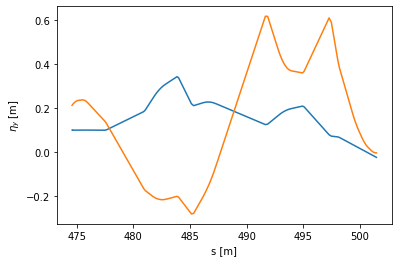

In [94]:
plt.plot(twiss.spos, twiss.etay)
plt.plot(twiss.spos, twiss.etax)
# plt.plot(default_twiss.spos, default_twiss.etay)
plt.ylabel('$\eta_y$ [m]')
plt.xlabel('s [m]')

In [89]:
s = sim.tune_crossing_vel
c = np.min(np.abs(sim.tunes[0]-sim.tunes[1]))
tr = sim.BO_REV_PERIOD
t = -tr*sim.deltas/(s*c**2)

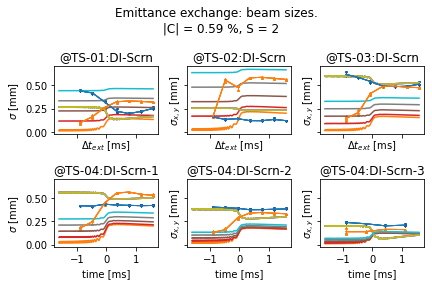

In [104]:
fig, ax = plt.subplots(2, 3, sharey=True, sharex=True)

etasy = np.linspace(0, 3e-1, 5)
for n, _ in enumerate(etasy):
    i,j = 0, 0
    for idx, label in enumerate(labels):
        bo_twiss2 = bo_twiss.copy()
        bo_twiss2.etay = etasy[n]

        #Eq params and twiss
        bo_eqparams = pa.optics.EqParamsFromBeamEnvelope(bo)
        twiss, _ = pa.optics.calc_twiss(ts, bo_twiss2)
        energy_spread = bo_eqparams.espread0
        ltwiss = twiss[screens_indices[idx]]
        betas = np.array([ltwiss.betax, ltwiss.betay])[:, None]
        etas = np.array([ltwiss.etax, ltwiss.etay])[:, None]
        emittances = sim.emittances
        beam_sizes = np.sqrt(emittances * betas + (etas * energy_spread)**2)
    #     t = -sim._delta2time(-sim.deltas)

        ax[i, j].plot(t, beam_sizes[0]*1e3, label='$\sigma_x$', alpha=1)
        ax[i, j].plot(t, beam_sizes[1]*1e3, label='$\sigma_y$', alpha=1)      
        ax[i, j].set_title(labels[i])
        pickname = f'/home/jucelio/experiments/2022-04-25-BO-emittance_exchange_optimization/emit_exchange_scan_scrn{idx+1:1d}_0p5slower.pickle'
        meas = load_pickle(pickname) 
        plot_ext_time_scan(meas, idx+1, time_offset=-0.40 ,figname=None, legend=False, axis=ax[i, j])

        if j == 0:
            ax[i, j].set_ylabel('$\sigma$ [mm]')
        if i == 1:
            ax[i, j].set_xlabel('time [ms]')
        ax[i, j].set_title('@' + label)
    #     ax[i, j].legend(loc='best')
        j+=1
        if j == 3:
            i += 1
            j = 0
fig.suptitle(f'Emittance exchange: beam sizes. \n |C| = {sim.coupling_coeff*100:.2f} %, S = {sim.tune_crossing_vel}' )
plt.tight_layout()
plt.savefig(f'figures/emit_exchange_studies/beam_sizes_data_only_dispersive_s{s}_c{c}.png', facecolor='white', transparent=False, dpi=300)

In [105]:
etasy

array([0.   , 0.075, 0.15 , 0.225, 0.3  ])

I found that a initial vertical dispersion of $\approx$ 0.01 explain some of the results, lets insert that since the begin of the simulation.

## Teorical beam sizes by tracking

Inserting dipole rotation errors and correcting the orbit, tunes and coupling

In [150]:
c = 0.0061
s = 2
error_angle = 3.5e-3  # [rad]
sim = EmittanceExchangeSimul(s=s, c=c, init_delta=-0.073, radiation=True, quad='QF')

famdata = pm.bo.get_family_data(sim.model)
dips_id = famdata['B']['index']

# Adding dipole rotation error near the extraction septum>
pa.lattice.set_error_rotation_roll(sim.model, dips_id[47], error_angle)

In [151]:
twiss2, _ = pa.optics.calc_twiss(sim.model)
eqparams = pa.optics.EqParamsFromBeamEnvelope(sim.model)
print('Tunes: ', eqparams.tune1, eqparams.tune2)
print('Emittances', eqparams.emit1, eqparams.emit2)
print('~~ Coupling', sim.coupling_coeff)

Tunes:  0.22900722796266806 0.307884526527977
Emittances 3.3086022969683647e-09 3.113761664292596e-10
~~ Coupling 0.05852164357955599


Text(0.5, 1.0, 'Orbit without correction')

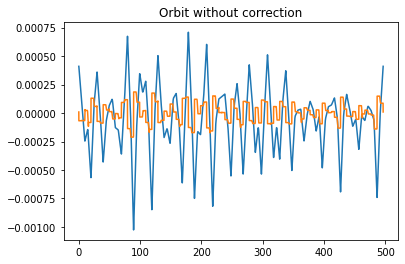

In [152]:
orbit = pa.tracking.findorbit6(sim.model, indices='open')
plt.plot(twiss2.spos, orbit[0])
plt.plot(twiss2.spos, orbit[1])
plt.title('Orbit without correction')

In [153]:
orbcorr = OrbitCorr(model=sim.model, acc='BO')
orbcorr.correct_orbit()

1

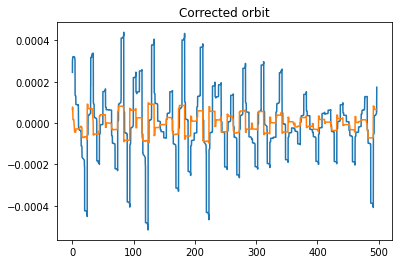

In [154]:
sim._model = orbcorr.respm.model[:]
corr_orbit = pa.tracking.findorbit6(sim.model, indices='open')
plt.plot(twiss2.spos, corr_orbit[0])
plt.plot(twiss2.spos, corr_orbit[1])
plt.title('Corrected orbit')
plt.show()

Correcting coupling and tunes separation

In [155]:
# Correcting coupling
sim._set_coupling(c)

#Correcting tunes
sim._set_initial_delta(init_delta=-0.073)

In [156]:
twiss2, _ = pa.optics.calc_twiss(sim.model)
etay = twiss2.etay
etax = twiss2.etax
eqparams = pa.optics.EqParamsFromBeamEnvelope(sim.model)
print('Tunes: ', eqparams.tune1, eqparams.tune2)
print('Emittances', eqparams.emit1, eqparams.emit2)
print('~~ Coupling', sim.coupling_coeff)

Tunes:  0.22942387190556915 0.3153970918180836
Emittances 3.2635756590047802e-09 5.008117495759652e-10
~~ Coupling 0.010802815122286412


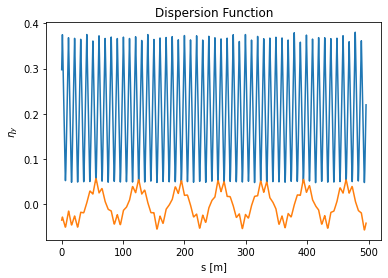

Vertical dispersion at extraction septa:  0.022286286379714915


In [157]:
plt.plot(twiss2.spos, etax)
plt.plot(twiss2.spos, etay)
septf_idx = pa.lattice.find_indices(sim.model, 'fam_name','EjeSeptF')
plt.xlabel('s [m]')
plt.ylabel('$\eta_y$')
plt.title('Dispersion Function')
plt.show()
print('Vertical dispersion at extraction septa: ', etay[septf_idx][0])

Making the tracking with the Booster in this configuration

In [ ]:
septf_idx = pa.lattice.find_indices(sim.model, 'fam_name','EjeSeptF')
# sim.env_emit_exchange(indices=septf_idx)
sim.generate_bunch(2000)
sim.part_emit_exchange()

In [158]:
plt.plot(sim.tunes[0])
plt.plot(sim.tunes[1])

TypeError: 'NoneType' object is not subscriptable

In [15]:
np.min(np.abs(sim.tunes[0] - sim.tunes[1]))

0.007142773567018423

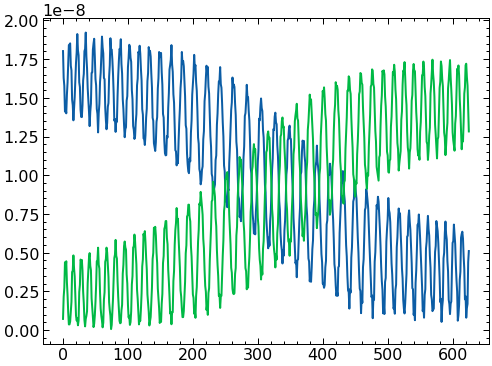

In [16]:
plt.plot(sim.emittances[0])
plt.plot(sim.emittances[1])
plt.show()
plt.figures

In [ ]:
bo_envelopes = sim.envelopes

In [ ]:
envelopes_at_screens = [] # Each indice means a single "injection"

for N in range(len(bo_envelopes)):
    init_env = bo_envelopes[N]
    env = pa.optics.calc_beamenvelope(
        accelerator=ts, fixed_point=np.zeros(6), init_env=init_env, indices=screens_indices)
    envelopes_at_screens.append(env)

In [64]:
save_pickle(sim, f'data/sim_object_s={s}_c={c}_dip_rot_errors_{error_angle}')

In [79]:
sim = load_pickle(f'data/sim_object_s={s}_c={c}')
# sim = load_pickle(f'data/sim_object_s={s}_c={c}_dip_rot_errors_{error_angle}')
# sim = load_pickle('data/sim_object_s=2_c=0.007142773567018423_dip_rot_errors_0.0035.pickle')

Tracking the envelopes through the TS

In [94]:
bo_envelopes = sim.envelopes

In [96]:
sigmax_at_screens = np.zeros([len(labels), len(envelopes_at_screens)])
sigmay_at_screens = sigmax_at_screens.copy()

In [97]:
for inj_idx in range(len(envelopes_at_screens)):
    env_screens = envelopes_at_screens[inj_idx]
    sigmax_at_screens[:, inj_idx] = np.sqrt(env_screens[:, 0, 0])
    sigmay_at_screens[:, inj_idx] = np.sqrt(env_screens[:, 2, 2])

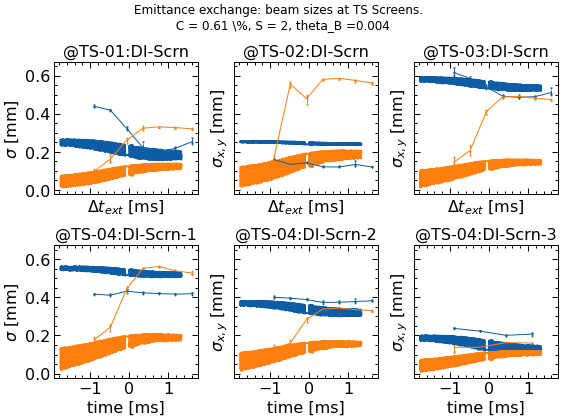

In [98]:
# with plt.style.context(['science', 'nature']):
    t = sim._delta2time(sim.deltas)
    fig, ax = plt.subplots(2, 3, sharey=True, sharex=True)
    i,j = 0, 0
    for idx, label in enumerate(labels):
        pickname = f'/home/jucelio/experiments/2022-04-25-BO-emittance_exchange_optimization/emit_exchange_scan_scrn{idx+1:1d}_0p5slower.pickle'
        meas = load_pickle(pickname)       
        ax[i, j].plot(t, sigmax_at_screens[idx]*1e3, label='$\sigma_x$',c='C0')
        ax[i, j].plot(t, sigmay_at_screens[idx]*1e3, label='$\sigma_y$', c='tab:orange')
        ax[i, j].set_title(labels[i])
        plot_ext_time_scan(meas, idx+1, time_offset=-0.40 ,figname=None, legend=False, axis=ax[i, j])
        if j == 0:
            ax[i, j].set_ylabel('$\sigma$ [mm]')
        if i == 1:
            ax[i, j].set_xlabel('time [ms]')
        ax[i, j].set_title('@' + label)
#         ax[i, j].legend(loc='best')
        j+=1
        if j == 3:
            i += 1
            j = 0
    fig.suptitle(f'Emittance exchange: beam sizes at TS Screens. \n C = {sim.coupling_coeff*100:.2f} \%, S = {sim.tune_crossing_vel}, theta_B ={error_angle}')
    plt.tight_layout()
    plt.savefig(
        f'figures/emit_exchange_studies/ts_beam_sizes_envtracking_s={s}_c={c}_dip_rot_errors_{error_angle}.png',
        facecolor='white', transparent=False, dpi=300)

# Emittance exchange impact on the Booster optical functions 

In [81]:
bo0 = pm.bo.create_accelerator(energy=3e9)
bof = sim.model
# Putting the Booster in the emittance exchange extraction configuration
_, rmax_idx = sim._calc_exchange_quality()
K = sim._K_list[rmax_idx]
qfidxs = sim.qf_idxs
pa.lattice.set_attribute(
            lattice=bof, attribute_name='K', indices=qfidxs,
            values=K)

In [93]:
twi0, _ = pa.optics.calc_twiss(bo0, indices=septf_idx)
twif, _ = pa.optics.calc_twiss(bof, indices=septf_idx)

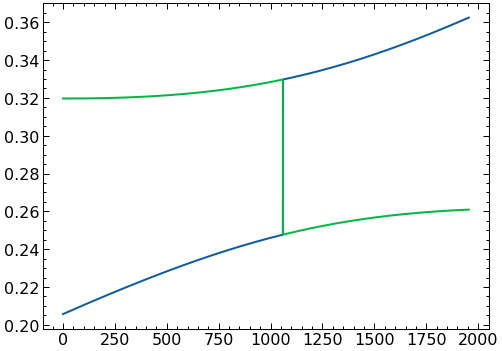

In [121]:
plt.plot(sim.tunes[0])
plt.plot(sim.tunes[1])

Twiss parameters at extraction septum (Without emittance exchange)

In [122]:
np.min(np.abs(sim.tunes[0] - sim.tunes[1]))

0.08193176120365564

In [94]:
print(twi0[0])

spos          : +4.746e+02
rx, ry        : +0.000e+00, +0.000e+00
px, py        : +0.000e+00, +0.000e+00
de, dl        : +0.000e+00, +0.000e+00
mux, muy      : +1.157e+02, +4.382e+01
betax, betay  : +7.885e+00, +1.237e+01
alphax, alphay: -2.407e+00, +2.038e+00
etax, etapx   : +2.127e-01, +7.011e-02
etay, etapy   : +0.000e+00, +0.000e+00


Twiss parameters at extraction septum (With emittance exchange)

In [96]:
print(twif[0])

spos          : +4.746e+02
rx, ry        : -4.950e-05, +4.318e-07
px, py        : -1.436e-05, -1.174e-07
de, dl        : -9.209e-05, -8.274e-02
mux, muy      : +1.163e+02, +4.369e+01
betax, betay  : +7.955e+00, +1.239e+01
alphax, alphay: -2.443e+00, +2.043e+00
etax, etapx   : +2.119e-01, +7.015e-02
etay, etapy   : -3.831e-03, +1.041e-03


Default initial Twiss parameters

In [97]:
ts, init_twiss = pm.ts.create_accelerator()
print(init_twiss)

spos          : +0.000e+00
rx, ry        : +0.000e+00, +0.000e+00
px, py        : +0.000e+00, +0.000e+00
de, dl        : +0.000e+00, +0.000e+00
mux, muy      : +0.000e+00, +0.000e+00
betax, betay  : +7.906e+00, +1.184e+01
alphax, alphay: -2.423e+00, +1.880e+00
etax, etapx   : +2.114e-01, +6.939e-02
etay, etapy   : +0.000e+00, +0.000e+00


Propagating the Twiss parameters through TS

In [105]:
ts_twi0, _ = pa.optics.calc_twiss(ts, twi0[0])
ts_twif, _ = pa.optics.calc_twiss(ts, twif[0])
ts_twi_init, _ = pa.optics.calc_twiss(ts, init_twi)

Beta function impact

In [115]:
%matplotlib qt5
spos = ts_twi_init.spos
plt.plot(spos, ts_twi0.betax, label = r'$\beta_{x,0}$')
plt.plot(spos, ts_twif.betax, label = r'$\beta_{x,f}$')
plt.plot(spos, ts_twi_init.betax, label = r'$\beta_{x,init}$')
plt.plot(spos, ts_twi0.betay, label = r'$\beta_{y,0}$')
plt.plot(spos, ts_twif.betay, label = r'$\beta_{y,f}$')
plt.plot(spos, ts_twi_init.betay, label = r'$\beta_{y,init}$')
plt.title('Betatron functions at TS for different initial conditions')
plt.xlabel('s [m]')
plt.ylabel(r'$\beta_{x,y}(s)$ [m]')
plt.legend()
plt.show()

Dispersion impact

In [117]:
%matplotlib qt5
spos = ts_twi_init.spos
plt.plot(spos, ts_twi0.etax, label = r'$\eta_{x,0}$')
plt.plot(spos, ts_twif.etax, label = r'$\eta_{x,f}$')
plt.plot(spos, ts_twi_init.etax, label = r'$\eta_{x,init}$')
plt.plot(spos, ts_twi0.etay, label = r'$\eta_{y,0}$')
plt.plot(spos, ts_twif.etay, label = r'$\eta_{y,f}$')
plt.plot(spos, ts_twi_init.etay, label = r'$\eta_{y,init}$')
plt.title('Dispersion functions at TS for different initial conditions')
plt.xlabel('s [m]')
plt.ylabel(r'$\eta_{x,y}(s)$ [m]')
plt.legend()
plt.show()

# Estuding the emittance oscilations

In [215]:
bo_init = sim.model[:]
bo_init.vchamber_on=False

In [216]:
env0 = pa.optics.calc_beamenvelope(bo_init)[0]

In [217]:
bunch = pa.tracking.generate_bunch(envelope=env0, n_part=1000)

In [218]:
turns = int(1e3)
emitx = np.zeros(turns)
emity = emitx.copy()
twi, *_ = pa.optics.calc_twiss(bo_init)
etax, etapx = twi.etax[0], twi.etapx[0]
etay, etapy = twi.etay[0], twi.etapy[0]
disp = np.array([[etax], [etapx], [etay], [etapy], [0], [0]])

# for n in range(turns):
bunchs, *_ = pa.tracking.ring_pass(
    accelerator=bo_init, particles=bunch, nr_turns=turns,
    turn_by_turn=True, parallel=True)
# bunch_nodisp = \
#     bunch - bunch[4, :]*disp - np.mean(bunch, axis=1)[:, None]
#     ex = np.sqrt(np.linalg.det(np.cov(bunch_nodisp[:2, :])))
#     ey = np.sqrt(np.linalg.det(np.cov(bunch_nodisp[2:4, :])))
#     emitx[n] = ex
#     emity[n] = ey
#     if i % 100 == 0:
#         print(f"step {i}", end='\t')
#     if i % 500 == 0:
#         print('\n')
#     if i == turns-1:
#         print('Done!')

In [219]:
for i in range(turns+1):
    bunch=bunchs[:, :, i]
    bunch_nodisp = \
    bunch - bunch[4, :]*disp - np.nanmean(bunch, axis=1)[:, None]
    ex = np.sqrt(np.linalg.det(np.cov(bunch_nodisp[:2, :])))
    ey = np.sqrt(np.linalg.det(np.cov(bunch_nodisp[2:4, :])))
    emitx[n] = ex
    emity[n] = ey

/home/jucelio/.local/lib/python3.6/site-packages/numpy/linalg/linalg.py:2159: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [ ]:
%matplotlib qt5
mask = bunchs[0, :, :]>-0.03
fig, ax = plt.subplots()
for i in range(turns+1):
    ax.cla()
    ax.scatter(bunchs[0, :, i], bunchs[1, :, i], s=0.4)
    plt.pause(0.5)

In [231]:
cropped_bunchs = bunchs[:, mask]

In [233]:
cropped_bunchs.shape

(6, 424873)

In [232]:
for i in range(turns+1):
    bunch=cropped_bunchs[:, :, i]
    bunch_nodisp = \
    bunch - bunch[4, :]*disp - np.nanmean(bunch, axis=1)[:, None]
    ex = np.sqrt(np.linalg.det(np.cov(bunch_nodisp[:2, :])))
    ey = np.sqrt(np.linalg.det(np.cov(bunch_nodisp[2:4, :])))
    emitx[n] = ex
    emity[n] = ey

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed